# 七章　畳み込みニューラルネットワーク(CNN)

本章では画像認識や音声認識に多く使われている**畳み込みニューラルネットワーク**(convolutional neural network:**CNN**)のメカニズムを説明、実際に実装していきます。

## CNNの構造

![全結合ニューラルネットワーク](https://i0.wp.com/liclog.net/wp-content/uploads/2020/08/8f616b86d0a2fc4a7257e22c8c712b52.png?ssl=1)

![CNN](https://leadinge.co.jp/rd/wp-content/uploads/2021/05/%E3%82%B9%E3%82%AF%E3%83%AA%E3%83%BC%E3%83%B3%E3%82%B7%E3%83%A7%E3%83%83%E3%83%88-50.png)

CNNは通常のニューラルネットワーク(隣接するすべてのニューロンを結合するため**全結合**と呼ばれる)に新たに「Convolutionレイヤ(**畳み込み層**)」と「Poolingレイヤ(**プーリング層**)」を加えたものです。プーリング層は省略されることもあります。

以前までの全結合では画像データなどに存在する入力データの空間的な関係性(色や位置関係のパターンなど)を無視して計算していましたが、CNNの畳み込み層では形状を維持して出力できます。この時の入出力データを**特徴マップ**といいます。

## 畳み込み層

![畳み込み演算](https://th.bing.com/th/id/R.7add1a346e2098a90db134b9485de33c?rik=y4PwOB1rdCsEdw&riu=http%3a%2f%2fwww.net.c.dendai.ac.jp%2f%7ekimura%2fimages%2fimg_8.png&ehk=ECmegNdXxpLwNxVV%2bKy71QPJRfrrc%2fCaGmYKm84YjHI%3d&risl=&pid=ImgRaw&r=0)

畳み込み層で行う処理を**畳み込み演算**といいます。この処理によって入力データはその形状を維持したまま出力することが可能になります。

図で示すように畳み込み演算とは**フィルター**、または**カーネル**と呼ばれるデータと入力データの差異を**積和演算**で求めることです。フィルターのパラメータはこれまでのニューラルネットワークで出てきた「重み」に当たります。

図には記載されていませんが、フィルターを適用した後にバイアス一つをすべての要素に加算する必要があります。

### パディング、ストライド、三次元データ

畳み込み層を繰り返し続けるといつかデータは1×1になってしまいそれ以上の演算が不可能になってしまいます。そのためフィルターを適用する際には入力データの端から適用していく必要がありますが、その際データが存在してないエリアとフィルターが重なりうまく計算ができないどいう事態が起きてしまいます。いわゆるnanという状態です。それを避けるためにも入力データの周囲に0などの固有のデータを埋める必要があります。これが**パディング**です。

また、フィルターはそのウィンドウを一定の間隔でスライドさせながら適用していきます。その時のスライドする間隔を**ストライド**といいます。ストライドの大きさに応じて出力データの大きさも変わり、ストライドを大きくしすぎてしまうと形状がうまく伝わらなくなってしまうので注意が必要です。

最後に、画像データの場合そのデータは三次元になります。その際には入力特徴マップは三枚、フィルターも三枚になります。そしてそれぞれの計算結果を加算して一枚の出力特徴マップにするのです。
もちろん、フィルターが一種類だけということはほとんどありません。画像の特徴を一言だけで説明できないのと同じです。そのためこの時の出力特徴マップはフィルターの数だけ存在することになります。

## プーリング層

![2×2Maxプーリング](https://www.koi.mashykom.com/image/maxpooling_1.png)

プーリング層では入力データを小さくします。画像認識の分野では一定のウィンドウの最大値を取り出すMaxプーリングが主に使われます。一般的にはプーリングの、ウィンドウの大きさとストライドは同じ値に設定されます。畳み込み層のストライドと同じように大きすぎると元の画像の形状を維持できなくなるため、この値は小さめになります。

プーリング層の特徴として、学習するパラメータがないため重みやバイアスについては考えなくていいこと、チャンネル数が変化しないためデータの枚数が入力時と出力時で変わらないこと、入力データの位置が少しずれても出力は同じ値になるため**ロバスト**(**頑強**)であることなどが言えます。

この中でもロバストであるという点は位置が少しずれただけである画像を同じものであると認識することができるという画像認識のカギとなります。

## 実装

最後に今まで学んだ二つのレイヤ、そしてそれを含んだCNNを実装してMNISTデータセットでその精度の高さを確認していきましょう。詳しい説明はよくわからなかったのでゼロつくを参考にしてください。

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.299293573715179
=== epoch:1, train acc:0.269, test acc:0.349 ===
train loss:2.296358363650064
train loss:2.2880775842798604
train loss:2.2830397763374672
train loss:2.2629002346692046
train loss:2.26430561885057
train loss:2.233516465302574
train loss:2.2206762636925363
train loss:2.213536047604752
train loss:2.1681900888147165
train loss:2.1583040373125786
train loss:2.08063930846061
train loss:2.0128094675168846
train loss:1.9930014044470468
train loss:1.9575621184968128
train loss:1.8022675785630256
train loss:1.8318447713448576
train loss:1.8104243687411665
train loss:1.692646514525211
train loss:1.7009481311165837
train loss:1.493025359659112
train loss:1.5025132624999378
train loss:1.3368580770494125
train loss:1.285107116967553
train loss:1.205191323344798
train loss:1.1083349523627914
train loss:1.0624259230457873
train loss:1.030154469357294
train loss:1.0093069972683342
train loss:0.922003432484008
train loss:0.8593874367893224
train loss:0.7371206392920087
train

train loss:0.2662567831253862
train loss:0.29910420408414373
train loss:0.3103774411360043
train loss:0.21311355935765403
train loss:0.40462421407030547
train loss:0.2303324703504107
train loss:0.3082144290177501
train loss:0.3932479967945149
train loss:0.24712105752721986
train loss:0.21633036525539218
train loss:0.13987715888532762
train loss:0.1553229669641388
train loss:0.1990040540715575
train loss:0.2178644363340942
train loss:0.29938829358126734
train loss:0.1851843600640635
train loss:0.17958020201508032
train loss:0.3805542965693533
train loss:0.25233097553175876
train loss:0.32028274231255943
train loss:0.285057919218535
train loss:0.12832427994024193
train loss:0.2783011098550515
train loss:0.10969737910932062
train loss:0.15306743910324114
train loss:0.23314665087682068
train loss:0.1971977808697383
train loss:0.28592747000979557
train loss:0.23351830830951187
train loss:0.2610520631636014
train loss:0.2033814931507342
train loss:0.1993863635213615
train loss:0.200069680532

train loss:0.08904960287335074
train loss:0.2005192363566404
train loss:0.1432309354659984
train loss:0.12094530720395566
train loss:0.09542586468531354
train loss:0.1933621254072281
train loss:0.17070285379213704
train loss:0.14321332051360366
train loss:0.0627535243326052
train loss:0.09517840102194386
train loss:0.1613997493720854
train loss:0.06173397240549944
train loss:0.12400363897588336
train loss:0.15438381951341076
train loss:0.2099661832478348
train loss:0.06430032900595033
train loss:0.0802816366456574
train loss:0.13580065394183394
train loss:0.11085886415452459
train loss:0.25237075168710016
train loss:0.08738162864928631
train loss:0.1439177754093564
train loss:0.09466189444186071
train loss:0.03436179050373309
train loss:0.1600196859834557
train loss:0.24925261898736223
train loss:0.21054258551784855
train loss:0.2073447805106623
train loss:0.11392809497036016
train loss:0.14062667582613253
train loss:0.08688287990984232
train loss:0.08677733189682627
train loss:0.08390

train loss:0.06501136893139116
train loss:0.05632390656436694
train loss:0.10746493434533287
train loss:0.07920468763070056
train loss:0.06116707350711756
train loss:0.07142014909912678
train loss:0.2499645274164384
train loss:0.13493054671814206
train loss:0.06357506329225841
train loss:0.08275811783947282
train loss:0.03632555537180429
train loss:0.07114475584002594
train loss:0.10875410748708818
train loss:0.06432473611343519
train loss:0.08802993555210076
train loss:0.1421641718259226
train loss:0.12643086127830494
train loss:0.04250273251380365
train loss:0.07457046469827593
train loss:0.0421242636036199
train loss:0.07127623075860492
train loss:0.08446194260541011
train loss:0.08369876016856281
train loss:0.13658144791232638
train loss:0.13215713762375197
train loss:0.042381497589027324
train loss:0.1949932424424155
train loss:0.056210973807757
train loss:0.08679340798237821
train loss:0.04125172986033263
train loss:0.08079397710491325
train loss:0.07289735470151607
train loss:0.

train loss:0.02392239312463155
train loss:0.08242353117603367
train loss:0.09825668509643137
train loss:0.09914380822769463
train loss:0.10456064374237174
train loss:0.03700499277442544
train loss:0.07151727975476356
train loss:0.10103489824498368
train loss:0.02776823639015613
train loss:0.04913318519958163
train loss:0.164664274896753
train loss:0.1772695743216295
train loss:0.011451717571220172
train loss:0.04542086920188613
train loss:0.1371615970598458
train loss:0.020009597454994876
train loss:0.0800591571802893
train loss:0.10628376894796876
train loss:0.046445186174503536
train loss:0.018877824361309945
train loss:0.06516475427091682
train loss:0.09954852052579195
train loss:0.032751297497157675
train loss:0.07490231083422469
train loss:0.05488686733891423
train loss:0.03641689008576772
train loss:0.07893095990722424
train loss:0.06564627838160335
train loss:0.04167512504647245
train loss:0.07350732841313154
train loss:0.04212849991836612
train loss:0.07559787577788021
train lo

train loss:0.07123742223447377
train loss:0.07208095800337573
train loss:0.02786778751780228
train loss:0.07028249671651295
train loss:0.0686638970008835
train loss:0.08534057441491752
train loss:0.02016528704512415
train loss:0.08441860846956752
train loss:0.03273956332632922
train loss:0.06013989844821432
train loss:0.03973456748133338
train loss:0.150372419506536
train loss:0.11092272603049017
train loss:0.03418852429891955
train loss:0.11664287205166395
train loss:0.08183553897173347
train loss:0.044015996740857544
train loss:0.02145012512942079
train loss:0.05217045979284662
train loss:0.07169357791701125
train loss:0.06251539901374717
train loss:0.03141936971995079
train loss:0.017337184706669107
train loss:0.03683983269061121
train loss:0.031022904630659265
train loss:0.0185518046236803
train loss:0.06108857924759464
train loss:0.04873735314031825
train loss:0.06506299536897504
train loss:0.10697603628419014
train loss:0.03383171847106832
train loss:0.03584955049382069
train los

train loss:0.053244972866573564
train loss:0.03601009695868184
train loss:0.03244207793812972
train loss:0.030337262363229468
train loss:0.12078820882201115
train loss:0.1611695146818069
train loss:0.09417362258342767
train loss:0.010517276107480654
train loss:0.05309393662582718
train loss:0.02955852825220383
train loss:0.015366247269448564
train loss:0.06923093236652163
train loss:0.01857467684863444
train loss:0.015008750690023791
train loss:0.053478795967008025
train loss:0.020126164589010016
train loss:0.037508058914504545
train loss:0.10514250602159539
train loss:0.10051931619358286
train loss:0.021874485078008998
train loss:0.013079217666062069
train loss:0.07846573665904612
train loss:0.06969408631304914
train loss:0.0338040781312201
train loss:0.027700276564002334
train loss:0.0695382389793161
train loss:0.05085797186089547
train loss:0.04859206239634143
train loss:0.017552492947879406
train loss:0.021085366745019526
train loss:0.07872587234230771
train loss:0.1151343423562105

train loss:0.011020077680883115
train loss:0.014325185519455257
train loss:0.06021917449837911
train loss:0.012244169198805954
train loss:0.039742502351472725
train loss:0.03314241068982225
train loss:0.0671657959796908
train loss:0.037696504022911206
train loss:0.1171886385805917
train loss:0.11465670906137872
train loss:0.025890523376301492
train loss:0.030549228506936945
train loss:0.021919647363250267
train loss:0.10896282928633053
train loss:0.07854150116553565
train loss:0.0370123939589759
train loss:0.01298835938051814
train loss:0.012597845576842438
train loss:0.01529603618736103
train loss:0.02395533006762428
train loss:0.09221773973619936
train loss:0.030962019413746288
train loss:0.04028795534696595
train loss:0.019175558906660454
train loss:0.05732268099295041
train loss:0.10793635655820039
train loss:0.04273021705257968
train loss:0.010150329851319459
train loss:0.048653695193833925
train loss:0.07450655750631216
train loss:0.037095308179540765
train loss:0.090093681110114

train loss:0.054817867447458674
train loss:0.03234554390956422
train loss:0.02578353101923614
train loss:0.012633490932924167
train loss:0.009237347997448206
train loss:0.006363068049694579
train loss:0.0903577474931325
train loss:0.07272418327174066
train loss:0.06504717410120273
train loss:0.05768189478285159
train loss:0.0045849761568325705
train loss:0.011691347508040895
train loss:0.07206024119647181
train loss:0.009315951787043194
train loss:0.03372153633845699
train loss:0.0592352295167415
train loss:0.06267907999200158
train loss:0.07302438838997538
train loss:0.027538814180452797
train loss:0.13516283062514348
train loss:0.12306826985021597
train loss:0.02664882716591975
train loss:0.024008404592911304
train loss:0.07868695948469555
train loss:0.04835598187726766
train loss:0.06938530116432644
train loss:0.03567327934171947
train loss:0.04833787253475802
train loss:0.04096500636932016
train loss:0.028229170802803696
train loss:0.06614475288868801
train loss:0.04364082239506106

train loss:0.021620932382371102
train loss:0.062341022732222875
train loss:0.0074072288042063275
train loss:0.10924999577579636
train loss:0.03283624018925222
train loss:0.020055430030929796
train loss:0.01572255847470081
train loss:0.006897730672900127
train loss:0.04659898095446031
train loss:0.07802755931168762
train loss:0.058068366222069547
train loss:0.04965713550187061
train loss:0.0158330603524704
train loss:0.01469748431375982
train loss:0.03680690874705081
train loss:0.03644955656317908
train loss:0.023129177398587143
train loss:0.01649853834062771
train loss:0.02416261831712406
train loss:0.028969178924069364
train loss:0.01807546060994073
train loss:0.04388672903647871
train loss:0.023499994801454437
train loss:0.04827888510910428
=== epoch:5, train acc:0.988, test acc:0.978 ===
train loss:0.02018029691630201
train loss:0.08138690792593697
train loss:0.010308676726495571
train loss:0.08447116031889369
train loss:0.02402548842121746
train loss:0.03105540537423538
train loss:

train loss:0.06415956239682065
train loss:0.031133187612413446
train loss:0.03867116914212028
train loss:0.00574079374971056
train loss:0.03051174755075685
train loss:0.035799716695048
train loss:0.013242662074007705
train loss:0.013346580879616776
train loss:0.025776019690811034
train loss:0.004906605272503085
train loss:0.009813832450488273
train loss:0.031841575525637
train loss:0.01941424152237929
train loss:0.021100716917242548
train loss:0.005032160339681692
train loss:0.024813093388029898
train loss:0.019320589574967784
train loss:0.051520873280006485
train loss:0.020094983871906745
train loss:0.014018998630174896
train loss:0.023421749950041048
train loss:0.012951086026802387
train loss:0.014541556666826128
train loss:0.03385392912450536
train loss:0.004615559672194485
train loss:0.019999694675773446
train loss:0.022664634642724356
train loss:0.02655475870382745
train loss:0.02357314133874421
train loss:0.012479704876261554
train loss:0.04046786212755464
train loss:0.0208946520

train loss:0.026939073477476656
train loss:0.03597646062229529
train loss:0.021321681933333593
train loss:0.02998098470852687
train loss:0.02023548989015492
train loss:0.054997670940162655
train loss:0.15844470929563811
train loss:0.006170637464475306
train loss:0.030500514919154603
train loss:0.044781405730044195
train loss:0.005208432822108262
train loss:0.011492180328719855
train loss:0.019655482529357938
train loss:0.012535318507468675
train loss:0.010630215276761595
train loss:0.03642573472835941
train loss:0.027476454900815697
train loss:0.024182766394447643
train loss:0.039002376956789896
train loss:0.050894377731483524
train loss:0.0385686107960417
train loss:0.010334874540693073
train loss:0.02306149531019319
train loss:0.015250287630775058
train loss:0.01500402386357362
train loss:0.015111144305710674
train loss:0.013928394827919683
train loss:0.020994217920581627
train loss:0.045243187004515656
train loss:0.05344154000961515
train loss:0.022500744671694446
train loss:0.01730

train loss:0.009262214963943529
train loss:0.016245223013389504
train loss:0.012935847528292424
train loss:0.21346622070771537
train loss:0.031201653819024188
train loss:0.01873130667474285
train loss:0.010590904146618068
train loss:0.013806789904920203
train loss:0.03399826008263265
train loss:0.010762023625401374
train loss:0.0034171756603272206
train loss:0.055598635107957345
train loss:0.015999113390397047
train loss:0.008539361841146596
train loss:0.013199222159314685
train loss:0.05636444131265268
train loss:0.032629948880685405
train loss:0.01966212928191757
train loss:0.023943178958342092
train loss:0.028608503927743865
train loss:0.04156023139244497
train loss:0.04031042988960208
train loss:0.02720879311241272
train loss:0.003206045022967891
train loss:0.03275668662828268
train loss:0.004485584474600593
train loss:0.005491812732737828
train loss:0.04169576046015943
train loss:0.013040841303264444
train loss:0.00574678341612571
train loss:0.01968998017382966
train loss:0.027634

train loss:0.04726119285644247
train loss:0.005788898151065844
train loss:0.08449301854732287
train loss:0.01714783209988221
train loss:0.009257956883111585
train loss:0.0018750496507953566
train loss:0.049726773223303204
train loss:0.007700528332454929
train loss:0.00645870220138486
train loss:0.037725536075372254
train loss:0.021322066364524956
train loss:0.013674631718303418
train loss:0.01804378563946231
train loss:0.024682570136126687
train loss:0.03416117652760442
train loss:0.004874430777129113
train loss:0.022443074065451193
train loss:0.028179887717561018
train loss:0.027325419315170633
train loss:0.009021186464074871
train loss:0.04720076467013309
train loss:0.0051451197848605325
train loss:0.035201018944961276
train loss:0.009229226263429072
train loss:0.002801312988767753
train loss:0.013698257148102633
train loss:0.018009116470723018
train loss:0.04211799283546698
train loss:0.02671990121260572
train loss:0.009460674698760895
train loss:0.08103567849161948
train loss:0.004

train loss:0.03726345846434052
train loss:0.007752218532445592
train loss:0.006965776950203794
train loss:0.031200795870749972
train loss:0.02270490252332231
train loss:0.017310304806658693
train loss:0.008950472302822803
train loss:0.04670804560072857
train loss:0.028855603252477047
train loss:0.004681541888314152
train loss:0.04170074482645077
train loss:0.006923064110114548
train loss:0.018795114049894684
train loss:0.022305610599685267
train loss:0.014002877010589927
train loss:0.04357066537053166
train loss:0.020609777814246263
train loss:0.02126103174553786
train loss:0.003261033480514998
train loss:0.03290847290879532
train loss:0.011217420640293218
train loss:0.0038938323498945277
train loss:0.01145672529572425
train loss:0.053295291270894427
train loss:0.008668128395811369
train loss:0.0031831018368200905
train loss:0.001172459262103168
train loss:0.011444351937348229
train loss:0.008468676796714947
train loss:0.030552836849812817
train loss:0.0022092948857233012
train loss:0.

train loss:0.0027568311689272155
train loss:0.030161591697615203
train loss:0.00812602809323169
train loss:0.003965873040452732
train loss:0.008179760029386968
train loss:0.005839096887009354
train loss:0.011919736622492247
train loss:0.008848564993282139
train loss:0.009685298651897278
train loss:0.005227112143179271
train loss:0.006610164013993934
train loss:0.008074171651008648
train loss:0.005865020345699242
train loss:0.02234160699602229
train loss:0.015796261724664817
train loss:0.01651232910169947
train loss:0.013963209841365239
train loss:0.08445487654272973
train loss:0.05439404254574409
train loss:0.010906784095303202
train loss:0.008972137701795588
train loss:0.007707707336861649
train loss:0.0022830999412580552
train loss:0.018279052464158275
train loss:0.005283465628497781
train loss:0.01633516855252789
train loss:0.010161867472858526
train loss:0.03409566273694672
train loss:0.002479695496465923
train loss:0.031079000279624184
train loss:0.007390571929729937
train loss:0.

train loss:0.015815290055027843
train loss:0.014016984950455745
train loss:0.021858858834543797
train loss:0.005794848292867616
train loss:0.022662813357002397
train loss:0.059184401661188844
train loss:0.006081037091128302
train loss:0.0025714412655026358
train loss:0.01116164532682362
train loss:0.0076028755151409935
train loss:0.0026587701983646584
train loss:0.010838579422568724
train loss:0.0289698794697685
train loss:0.08010681349761267
=== epoch:8, train acc:0.99, test acc:0.985 ===
train loss:0.013004065616338534
train loss:0.0052016910184362955
train loss:0.004971083075307402
train loss:0.004030191177464838
train loss:0.005123179417112354
train loss:0.009890826435841741
train loss:0.013675204217323354
train loss:0.01592221016418823
train loss:0.08151874655976446
train loss:0.0056291525071467926
train loss:0.002380946962057999
train loss:0.05544744071748971
train loss:0.003056219299466114
train loss:0.011735100428854077
train loss:0.001456193203955921
train loss:0.0242580696604

train loss:0.032489421110461075
train loss:0.009450573401698279
train loss:0.004009135822210142
train loss:0.005176745293238909
train loss:0.034482506494643204
train loss:0.031010870146074176
train loss:0.0022187504786743066
train loss:0.028739624023251916
train loss:0.0026776964982180144
train loss:0.0018359733834160306
train loss:0.0020421662311524294
train loss:0.01581876747413384
train loss:0.036504927578172676
train loss:0.007473036816152713
train loss:0.0025196766181297815
train loss:0.0029621522035629395
train loss:0.0035277391705746215
train loss:0.002168082281611437
train loss:0.010619448460822573
train loss:0.003536904467098162
train loss:0.00625209094509603
train loss:0.007796527569089659
train loss:0.0064407393182618865
train loss:0.005855616480373273
train loss:0.033839482002515395
train loss:0.0030203300198016936
train loss:0.00399151205372675
train loss:0.006551349298568134
train loss:0.01215750844842408
train loss:0.0056886284890341025
train loss:0.010642609748831779
tr

train loss:0.015180171069282126
train loss:0.011487441786221263
train loss:0.039006893127114084
train loss:0.0016584729856929114
train loss:0.00289234889762867
train loss:0.034607120748124526
train loss:0.009923202027683611
train loss:0.0016982263974362117
train loss:0.061628161434186805
train loss:0.014260857878264898
train loss:0.007266383590856715
train loss:0.0028480000312380055
train loss:0.004039364863337066
train loss:0.007874596949987111
train loss:0.021902146331788542
train loss:0.0015679620467926355
train loss:0.04078485688264768
train loss:0.00871491345632358
train loss:0.006784652279242125
train loss:0.00698387052619622
train loss:0.0018804693382678804
train loss:0.018827727654416957
train loss:0.011432597775595209
train loss:0.018561973920797333
train loss:0.0013783364597239492
train loss:0.0049357426609493195
train loss:0.010629264682414739
train loss:0.008576963188594968
train loss:0.007736195634377077
train loss:0.048837425553268664
train loss:0.0023948239913254344
trai

train loss:0.0036056374412250713
train loss:0.006507206494384902
train loss:0.0040548910641708185
train loss:0.005559547285366916
train loss:0.016511767840916833
train loss:0.027668218767434118
train loss:0.009033371029618566
train loss:0.008352468943651901
train loss:0.006828367072066069
train loss:0.02010164103687441
train loss:0.008495826277910092
train loss:0.006548668121097914
train loss:0.00623637788567995
train loss:0.005258041961957136
train loss:0.003507513303953899
train loss:0.0089548316564446
train loss:0.0036114869601472747
train loss:0.019074480545013924
train loss:0.010807842364276758
train loss:0.0019979045764881
train loss:0.02338079994694851
train loss:0.006256045343134692
train loss:0.030411035738367117
train loss:0.0005926106107909171
train loss:0.03394255951915542
train loss:0.021160312276465955
train loss:0.0074360340122390225
train loss:0.015882120393134982
train loss:0.01255279537851253
train loss:0.003413776976571201
train loss:0.006834232705236464
train loss:0

train loss:0.002154631846291982
train loss:0.0022263959174029656
train loss:0.0030449920948163417
train loss:0.007047279468113531
train loss:0.00568186102744111
train loss:0.0011066232492496332
train loss:0.0070163248390414275
train loss:0.00391187214482387
train loss:0.002869025658353418
train loss:0.027794395779451916
train loss:0.01175697695070598
train loss:0.0033815155745142954
train loss:0.025346737628354207
train loss:0.009318287452001313
train loss:0.003651443843053612
train loss:0.008582430764594457
train loss:0.000679885920199153
train loss:0.01286207710563277
train loss:0.008064642211929506
train loss:0.003282896814548986
train loss:0.009048968560866925
train loss:0.014194557641871063
train loss:0.00231243996466224
train loss:0.010680083867369876
train loss:0.014787340322932403
train loss:0.0037541710869641244
train loss:0.0011455593671147752
train loss:0.0033770402879544337
train loss:0.0073740351831746
train loss:0.005023685378095087
train loss:0.0066760806608221635
train 

train loss:0.0018154971434390726
train loss:0.006580211010333546
train loss:0.004013895118432151
train loss:0.0044798053639514505
train loss:0.010636146883658226
train loss:0.1333877736701505
train loss:0.0030878863133540126
train loss:0.007009919189995904
train loss:0.01954294479027927
train loss:0.0008476890769027347
train loss:0.009898108078699841
train loss:0.0031606289285547647
train loss:0.0009545869561590376
train loss:0.02840242278309915
train loss:0.001617670496629069
train loss:0.004155024605250139
train loss:0.008467694769625276
train loss:0.004800169616471572
train loss:0.0017405400896181253
train loss:0.010136059416061277
train loss:0.0010478872162306824
train loss:0.006202737708950248
train loss:0.00335436115344692
train loss:0.004245770924041499
train loss:0.006989862210923716
train loss:0.012664273013738143
train loss:0.0021300291038788745
train loss:0.005834116724591593
train loss:0.00598956394845002
train loss:0.0019351383908882897
train loss:0.0023899557966702615
tra

train loss:0.02107104127152486
train loss:0.0006461319292907477
train loss:0.004805998050573215
train loss:0.0050398308699864365
train loss:0.024306333745183206
train loss:0.016433072401642376
train loss:0.01591892130011052
train loss:0.0048317547423990595
train loss:0.004896194142650942
train loss:0.005907360911730049
train loss:0.006473982447725583
train loss:0.0030535526381513436
train loss:0.010283097994273165
train loss:0.010308960685461246
train loss:0.0039544817236186955
train loss:0.0050610904297152684
train loss:0.03138699019869205
train loss:0.009800847748985639
train loss:0.0019756760460929094
train loss:0.009687715629904548
train loss:0.0026032439140990797
train loss:0.0013618448472886913
train loss:0.007347910913428244
train loss:0.00461209029648227
train loss:0.0031622788328385548
train loss:0.008668655629634902
train loss:0.02052186934491971
train loss:0.0071442478623230795
train loss:0.003102625457633319
train loss:0.004059480343619009
train loss:0.07472679245305754
tra

train loss:0.006522851735326735
train loss:0.018392034200197957
train loss:0.0018622193901655314
train loss:0.0016506976757235132
train loss:0.002658079451289262
train loss:0.0007520790931983914
train loss:0.009268119340029211
train loss:0.011377428253323085
train loss:0.008883073343896928
train loss:0.0020526543146393507
train loss:0.0035614921775043882
train loss:0.0010326614538256485
train loss:0.004439051544075665
train loss:0.00114319368159158
train loss:0.008458661744232902
train loss:0.005156780291324744
train loss:0.004527648165961319
train loss:0.005351195720106558
train loss:0.0011716389113281972
train loss:0.005086267388049969
train loss:0.002054979830640799
train loss:0.0030466991805481124
train loss:0.00931854966797175
train loss:0.0017624683011302964
=== epoch:11, train acc:0.993, test acc:0.99 ===
train loss:0.006950961607726659
train loss:0.003353460230164033
train loss:0.0036284775610838853
train loss:0.004341954326494789
train loss:0.019308987075798492
train loss:0.02

train loss:0.005735604048384043
train loss:0.0029176803227571363
train loss:0.005332532379688284
train loss:0.005349360383210482
train loss:0.030184237992167306
train loss:0.006798924979763309
train loss:0.0071047927494152004
train loss:0.00409291522630681
train loss:0.0006326669641156435
train loss:0.02076118338076606
train loss:0.0016747053384779404
train loss:0.04969978331913122
train loss:0.009171389910035075
train loss:0.017381899654080924
train loss:0.002234066118686462
train loss:0.012081128633100666
train loss:0.002614698711851684
train loss:0.007489039239182137
train loss:0.005976781542287441
train loss:0.003288934488540172
train loss:0.010856192857084144
train loss:0.01161890298323704
train loss:0.007204848463417628
train loss:0.011061385766983345
train loss:0.0038984405970733417
train loss:0.0023378363865743258
train loss:0.0944501129342811
train loss:0.006691812953579928
train loss:0.0019826146290769222
train loss:0.0013846730775236322
train loss:0.0074690952289865175
train

train loss:0.0007605974019172613
train loss:0.011464538074715043
train loss:0.00041099454545577444
train loss:0.003179250860615151
train loss:0.032916330904741595
train loss:0.010150176078970974
train loss:0.005218034491081975
train loss:0.003249446537486568
train loss:0.018149460982142835
train loss:0.0038405618063836588
train loss:0.031902261251505325
train loss:0.0090855010006452
train loss:0.006687276551302175
train loss:0.0013925119925394418
train loss:0.08863481081121495
train loss:0.0026257038392630883
train loss:0.007028411292725776
train loss:0.0012196243823068744
train loss:0.0034016710375792663
train loss:0.0052838821936012585
train loss:0.003947473433425015
train loss:0.004408554580344972
train loss:0.0115149551771234
train loss:0.008447367944075815
train loss:0.000504988561152342
train loss:0.009111313786006759
train loss:0.007235149986710027
train loss:0.004378150375043041
train loss:0.030415329389833975
train loss:0.0009311359762353169
train loss:0.0037826694745715967
tr

train loss:0.00022416163534898497
train loss:0.0044486656526750235
train loss:0.011007315358435727
train loss:0.0033512549105195657
train loss:0.06361407885027501
train loss:0.00705120691057851
train loss:0.0013469781312707857
train loss:0.001156009189808488
train loss:0.0036965062142639902
train loss:0.004404952141008437
train loss:0.0012414644666393177
train loss:0.01147307782400522
train loss:0.001275676327955105
train loss:0.0027846021596730553
train loss:0.005068002613854874
train loss:0.004459953230376386
train loss:0.0019747919036237765
train loss:0.010636435798107668
train loss:0.005709356028616401
train loss:0.004923933319430846
train loss:0.004893839807645612
train loss:0.01129511847080913
train loss:0.0008126580185608093
train loss:0.004955523174219803
train loss:0.03782598847082388
train loss:0.010378127931180002
train loss:0.0013714124398649834
train loss:0.0008294786637985434
train loss:0.002323139587796396
train loss:0.0011105213717246174
train loss:0.0017597587441775273

train loss:0.002672527253812716
train loss:0.0032364661788462186
train loss:0.006715942155493549
train loss:0.0012196594117363463
train loss:0.0027663422769387967
train loss:0.0004521034339915913
train loss:0.0003583482611329696
train loss:0.0020883953735411575
train loss:0.0003850921327751575
train loss:0.002929207222939662
train loss:0.004487772457814086
train loss:0.0010627053020869038
train loss:0.002570842751486499
train loss:0.0007046682809392839
train loss:0.0013010725941423416
train loss:0.0037289592211016396
train loss:0.0027603914839680905
train loss:0.006283516827845428
train loss:0.004356871628654191
train loss:0.00217201962663606
train loss:0.01162145325345779
train loss:0.0007453701381154057
train loss:0.0005168501731170824
train loss:0.0012643605802181682
train loss:0.0010764806847327203
train loss:0.002163974656104451
train loss:0.004628492833539653
train loss:0.002117849329360012
train loss:0.0005520722924603607
train loss:0.001670245549739705
train loss:0.000688351172

train loss:0.004705904356360588
train loss:0.006033425528612714
train loss:0.003447841078484079
train loss:0.012446376417888294
train loss:0.00786307637617281
train loss:0.01359148466740897
train loss:0.009214143692018896
train loss:0.0034986375796034488
train loss:0.003612650809110764
train loss:0.002412791767589348
train loss:0.007270646418615558
train loss:0.008045582709102541
train loss:0.002367205351783363
train loss:0.01224557463117113
train loss:0.011719263831055642
train loss:0.0029095041560132577
train loss:0.0019932914457339813
train loss:0.004844981379255741
train loss:0.012109878283070894
train loss:0.0047259112949364045
train loss:0.0015143078910671102
train loss:0.004101810722181048
train loss:0.003241946711019507
train loss:0.005260083144184033
train loss:0.008208442644380873
train loss:0.015672024272526407
train loss:0.0038359936881237127
train loss:0.0002625066673297446
train loss:0.0031485873903252803
train loss:0.006232976436241616
train loss:0.002774956684243744
tra

train loss:0.005750063991688755
train loss:0.0033423527001748797
train loss:0.002432055856639562
train loss:0.00037676698263539705
train loss:0.0032174100105289917
train loss:0.000739744751121571
train loss:0.002612011916298427
train loss:0.005568214741460419
train loss:0.0011844058429517682
train loss:0.002507802249718706
train loss:0.0024299003091379587
train loss:0.0013676093309929766
train loss:0.0020195137060965707
train loss:0.005144514017634157
train loss:0.0009653872641688382
train loss:0.0012831438854910419
train loss:0.007772704947696638
train loss:0.0018895976431636769
train loss:0.0006419695763448525
train loss:0.0005831471481608074
train loss:0.009223472916386343
train loss:0.0005801640189420388
train loss:0.002505178598825593
train loss:0.0015704003383029035
train loss:0.003873496803191086
train loss:0.003470002380028052
train loss:0.0022497427654063875
train loss:0.0045960912247488914
train loss:0.0009093587296954713
train loss:0.0029292935182529266
train loss:0.01121822

train loss:0.0016782009051488672
train loss:0.0029125528271396837
train loss:0.0005226999021699428
train loss:0.0042617521850802885
train loss:0.001381241497930748
train loss:0.012084014834187345
train loss:0.0067098693228925975
train loss:0.0008727604794149307
train loss:0.01393170549287031
train loss:0.007198068087637648
train loss:0.021480363495457594
train loss:0.0012515858137611335
train loss:0.012155823510786375
train loss:0.0010586135169170013
train loss:0.003760289384059003
train loss:0.0007296382213235268
train loss:0.003172288986691061
train loss:0.0009395498510898607
train loss:0.002586221853671958
train loss:0.006419767085497284
train loss:0.015558951229503355
train loss:0.0031876154150893136
train loss:0.0036374451393112956
train loss:0.0016045056742814252
train loss:0.0001792393337368333
train loss:0.001606130291742302
train loss:0.000891158833957421
train loss:0.0013467765697146804
train loss:0.005232808772022204
train loss:0.005835185516120101
train loss:0.0041461391153

train loss:0.0006276007210111797
train loss:0.001351742002147108
train loss:0.0015541959364567678
train loss:0.0011987872221317225
train loss:0.00458044595838648
train loss:0.0014354524063360955
train loss:0.00013946344780282208
train loss:0.0012859464401543742
train loss:0.0007022381889650961
train loss:0.00442402519098118
train loss:0.002843155368500445
train loss:0.00038086912751025446
train loss:0.0049901024928641095
train loss:0.0012289317852700382
train loss:0.006786551075840878
train loss:0.0010292131598886817
train loss:0.0006901321351603235
train loss:0.0009435654087706536
train loss:0.00047138979024144195
train loss:0.0020010664318370753
train loss:0.0015253997299568998
train loss:0.0015198407953016621
train loss:0.011619768704374023
train loss:0.016871526919263857
train loss:6.782836794739243e-05
train loss:0.0003826503018349782
train loss:0.002902012245160457
train loss:0.003170733754238209
train loss:0.0016682710112859297
train loss:0.0010905040188332715
train loss:0.00532

train loss:6.665664633375493e-05
train loss:0.0024661183269838907
train loss:0.0008676528762427974
train loss:0.0005019102501699089
train loss:0.0001481185024193947
train loss:0.0016181713837479712
train loss:0.002367703355170618
train loss:0.006975852950218813
train loss:0.001149549063998819
train loss:0.0018838976528320664
train loss:0.0010270837148150319
train loss:0.0006936372128879387
train loss:0.00123086707526681
train loss:0.00911857170165866
train loss:0.0005943129896437449
train loss:0.0005901082147791647
train loss:0.023784206871097405
train loss:0.005442625438474462
train loss:0.0007706989003808147
train loss:0.0003832541546536646
train loss:0.0004765180857402684
train loss:0.0027969081699636845
train loss:0.0008279346281980144
train loss:0.0016197478228942596
train loss:0.0012279603184884543
train loss:0.00022300158914197163
train loss:0.0017426188924697561
train loss:0.004417431389930327
train loss:0.0003029788382936695
train loss:0.00029961399784647315
train loss:0.02014

train loss:0.00041486410906731587
train loss:0.0019139134222704223
train loss:0.0013704104579926847
train loss:0.000427250031349316
train loss:0.004076014860879602
train loss:0.011390647416053824
train loss:0.004550814662572641
train loss:0.010138010422905684
train loss:0.003267432974787055
train loss:0.012231406416920849
train loss:0.0004916160467038631
train loss:0.0006806772479130795
train loss:0.0019679578846142436
train loss:0.002440711470206681
train loss:0.000978594611243484
train loss:0.0009188787424113043
train loss:0.001437380260393293
train loss:0.006279079966384889
train loss:0.002381083743656439
train loss:0.003069712627067461
train loss:0.0036563618485747434
train loss:0.003297380421324224
train loss:0.0021049789960991185
train loss:0.0032676845366162847
train loss:0.005477308639335193
train loss:0.0012429321912225662
train loss:0.0021080244252962826
train loss:0.005823304259307358
train loss:0.0040543421275662595
train loss:0.0024740383156005214
train loss:0.001626353076

train loss:0.0021813675747032134
train loss:0.002693763666984641
train loss:0.0017223265244714686
train loss:0.0007724274398681991
train loss:0.008491645237820726
train loss:0.011675284516547209
train loss:0.0016690649566276894
train loss:0.0002975440501047079
train loss:0.00011193507330784302
train loss:8.10972099299081e-05
train loss:8.935775313789706e-05
train loss:0.008587699668884053
train loss:0.0033841604291067833
train loss:0.0035334073418327116
train loss:0.0016649230507675486
train loss:0.00636348784497664
train loss:0.011906601436064255
train loss:0.0006274542625203367
train loss:0.0006193130188521314
train loss:0.002558900598101432
train loss:0.0009398098166251542
train loss:0.004110918007393339
train loss:0.0016178124796878276
train loss:0.0005504878837810526
train loss:0.004675952187322444
train loss:0.0002875636131937814
train loss:0.004094328740812705
train loss:0.0017176172552259227
train loss:0.0034555258774147902
train loss:0.0012298934536414579
train loss:0.00253880

train loss:8.255356330157828e-05
train loss:0.002092855411627053
train loss:0.002754644406854285
train loss:0.0035023328495679086
train loss:0.0058548715716135605
train loss:0.0016106024815675942
train loss:0.0006284034292718965
train loss:0.0055610538002157095
train loss:0.016278021593795315
train loss:0.00177992798941522
train loss:0.001681563681888938
train loss:0.0023071177313931423
train loss:0.0032619220729135745
train loss:0.0014811181461022815
train loss:0.0021403412623038566
train loss:0.00017797047492093868
train loss:0.0076554794092098385
train loss:0.0002422827844858633
train loss:0.002464801879182614
train loss:0.0006133745217753935
train loss:0.0018132053402698828
train loss:0.009041554667997716
train loss:0.011279456401727976
train loss:0.00340830224605571
train loss:0.0019993806699783218
train loss:0.0003478965029940196
train loss:0.0015382258456159462
train loss:0.004259565174376508
train loss:0.021698869761457608
train loss:0.0001256892756410085
train loss:0.010711291

train loss:0.0010037842051908747
train loss:0.0002357736488438092
train loss:0.00033208238149560657
train loss:0.00022879206549401024
train loss:0.00016285758135141436
train loss:0.0032028346846181104
train loss:0.0018392778231653745
train loss:0.001064971010303827
train loss:0.0028157320644608234
train loss:0.0009054544755340418
train loss:0.0024050553177954207
train loss:0.0004549894655713022
train loss:0.0018918922353341372
train loss:0.0019277282229770325
train loss:0.016150774620635112
train loss:0.00022543479224460675
train loss:0.0058454475573446255
train loss:0.00023353559022286238
train loss:0.0003383275600025098
train loss:0.0006298533603603197
train loss:0.0020207972077747934
train loss:0.0001472962808651347
train loss:0.000314245993299974
train loss:1.833645470310632e-05
train loss:0.0007784890332938881
train loss:0.004548557818949779
train loss:0.0040908861555341005
train loss:0.001368369774243692
train loss:0.0007619836475679139
train loss:0.0023482334914538073
train loss

train loss:0.00032456086283817346
train loss:0.00037939577958865213
train loss:0.0006951931756426007
train loss:0.0004400476772620524
train loss:0.0018415835773453646
train loss:0.00028378528023391723
train loss:0.0007280476322508535
train loss:0.0005073255586123097
train loss:0.0011749990215835476
train loss:0.005846574980831155
train loss:0.000260635355707868
train loss:0.0009200588674254605
train loss:0.00030705710867418023
train loss:0.0012207957832940516
train loss:0.0016508911642458953
train loss:0.0013426343189137803
train loss:0.006981559715704017
train loss:0.000773915205777132
train loss:0.0012031728116670365
train loss:0.00048259295419955564
train loss:0.0003952294872253721
train loss:0.000105541225554432
train loss:0.007785927319951037
train loss:0.0015777652979965372
train loss:0.005387756618138152
train loss:0.003647920371944799
train loss:0.0032595864098575555
train loss:0.001987324615282935
train loss:0.0001620472767481529
train loss:0.00027707811351617735
train loss:0.

train loss:0.0005564104272284787
train loss:0.009647208638989232
train loss:0.0029890508019231195
train loss:0.0018735479848366896
train loss:0.0036184600036671477
train loss:0.002469101903604943
train loss:0.0006149471775583479
train loss:0.00025647510320256123
train loss:0.0001910687718367296
train loss:0.005122540347471404
train loss:0.043543517333301265
train loss:0.0002029927220975541
train loss:0.000738236912494234
train loss:0.005064123417401184
train loss:0.0018654104203807322
train loss:0.0019901590463969627
train loss:0.004562220553374213
train loss:0.0026603667069991445
train loss:0.0011008214644659452
train loss:0.0056168000763027045
train loss:0.005900080558618369
train loss:0.002355094285472586
train loss:0.00999274233689922
train loss:0.0011673556305123508
train loss:0.004426945961275575
train loss:0.0005322007413572225
train loss:0.0017825224196652322
train loss:0.0012074393780772124
train loss:0.0009228398902237521
train loss:0.0021403523457918096
train loss:0.00266680

train loss:0.0027156168242288116
train loss:0.005265139924830266
train loss:0.0016164963549683655
train loss:0.005036827224905341
train loss:0.0025337645091190763
train loss:0.001062849086442627
train loss:0.0007480836562076395
train loss:0.0028284299206277467
train loss:0.001003153222322684
train loss:0.002369242232777528
train loss:0.00509522477063366
train loss:0.0016752667464984105
train loss:0.002176235955729985
train loss:0.001982636492819933
train loss:0.001620607763339454
train loss:0.0005128134491880124
train loss:0.0009076585928867674
train loss:0.010145354140517085
train loss:0.0010922291483708955
train loss:6.314630768707403e-05
train loss:0.004924137682673248
train loss:9.846697950459511e-05
train loss:8.03546352282121e-05
train loss:0.0006169568625429483
train loss:0.00832213279353605
train loss:0.0016051594570959471
train loss:0.0014305791447398455
train loss:0.0036777777919344812
train loss:0.00034736746032814074
train loss:0.0002882110463844835
train loss:0.00175695472

train loss:0.00427925949626797
train loss:0.0003393298803023578
train loss:0.0010583182448896888
train loss:0.000796641470315319
train loss:0.0017967393268077413
train loss:0.002074720984430153
train loss:0.001825762092365153
train loss:0.0005970533068839906
train loss:0.0007835787016649065
train loss:0.0026505727823308255
train loss:0.0054755390296737025
train loss:0.0010504801281745698
train loss:0.003674930014687563
train loss:0.0030082235767006625
train loss:0.006279200327206434
train loss:0.00027962047266400343
train loss:0.0073662651587025375
train loss:0.0015459526953991
train loss:0.001377551467069851
train loss:0.0009259728601460848
train loss:0.002327361329954178
train loss:0.0022008802873021887
train loss:0.0035663172971314473
train loss:2.10800044552983e-05
train loss:0.003741800541242265
train loss:0.003327771742120234
train loss:0.007260050315043256
train loss:0.0032114302236344867
train loss:0.0027968524849789206
train loss:0.00014975103782269267
train loss:0.00276575351

train loss:0.0010297590459144314
train loss:0.0011958005754582118
train loss:0.001245073594642531
train loss:0.00017311873211725283
train loss:0.00035045668581069395
train loss:0.001364112363873801
train loss:0.000536973158525157
train loss:0.006305947864003968
train loss:0.013126274275234598
train loss:0.004349191322618395
train loss:0.0007230761288464405
train loss:0.002808530161205198
train loss:0.000958512198078356
train loss:0.0006401159322666882
train loss:0.005457157776553567
train loss:0.00017919398469160464
train loss:0.003090761324964933
train loss:0.0008820433052244139
train loss:0.004979148918059254
train loss:0.0002188501017293048
train loss:0.0002989521912438544
train loss:0.0014270259992232722
train loss:0.00021551961234998884
train loss:0.0003977833175242527
train loss:0.0010076955181656075
train loss:0.000182119044898656
train loss:0.001545724085592837
train loss:0.0212261579072957
train loss:0.0006866685402570875
train loss:0.0005148200409601099
train loss:0.003042023

train loss:0.0012719507008889493
train loss:0.0001799491842657949
train loss:0.0007273466065251157
train loss:0.0001752630810827203
train loss:0.0007107083603418253
train loss:9.945408520416702e-05
train loss:0.0023245629539614863
train loss:0.00023567775609046777
train loss:0.0013576697061601084
train loss:0.007239365631694215
train loss:0.0006118930448006575
train loss:0.00010872638845751141
train loss:0.0001985887743691125
train loss:0.001078963967038993
train loss:0.006981283707846145
train loss:0.00017989647938626972
train loss:0.0015304723119263055
train loss:0.0028978950535495356
train loss:0.0007203756175414254
train loss:0.00012367952600944823
train loss:0.0002540828358318814
train loss:0.0022860970116936083
train loss:0.0010725634171446544
train loss:0.014392314018032584
train loss:2.718841575842593e-05
train loss:0.00175092577765824
train loss:0.0005553483198433284
train loss:0.0019200479710664137
train loss:0.00020057717357820095
train loss:0.00016741052809470344
train loss

train loss:0.0011653410487909247
train loss:0.002187089682981379
train loss:0.001638833848930001
train loss:0.0003821343958629609
train loss:0.001735352589778105
train loss:0.0009381123642464087
train loss:0.002608882295022799
train loss:0.001953809315935794
train loss:0.0002238433064569798
train loss:0.001141828196463016
train loss:0.00015826534836414758
train loss:0.0010063846670979634
train loss:0.0028646814810819794
train loss:0.010461142474381974
train loss:0.0014419826634708623
train loss:0.007450331308926129
train loss:0.0010971257007686144
train loss:0.0021917089098170335
train loss:0.0004321101524639707
train loss:0.0009900814333296004
train loss:6.778030562998141e-05
train loss:0.001952002449791234
train loss:0.0004264297614755596
train loss:0.001202411966197269
train loss:0.001535968147769938
train loss:0.00011659168469944883
train loss:0.0050413111439690786
train loss:0.0014107807498043282
train loss:0.0017412060425654513
train loss:0.0010405130683510556
train loss:0.002041

train loss:0.00017769459959258546
train loss:0.0019696063667173037
train loss:0.0030372775376369503
train loss:0.0006324574045969526
train loss:0.002018955692932759
train loss:0.002791503030372023
train loss:0.0001400591277736128
train loss:0.0007300027957355577
train loss:0.0027829672338638306
train loss:0.001791475948128404
train loss:0.0007789991722204257
train loss:0.0005478091728589364
train loss:0.001611287125424255
train loss:0.002355882598898411
train loss:0.024274597005369474
train loss:0.004308768212555633
train loss:4.208453435362762e-05
train loss:0.002773648817677909
train loss:0.001177454973597031
train loss:0.00044211567169222585
train loss:0.006180786406352425
train loss:0.0018080433843077658
train loss:0.0007743106887883481
train loss:0.003265125443111103
train loss:8.349180516839596e-05
train loss:0.0013365067902838244
train loss:0.0002918424047237802
train loss:9.973095846810548e-05
train loss:0.0011533002532843214
train loss:0.0026338652114254193
train loss:0.004281

train loss:0.00041653586069951377
train loss:0.0008101399012242602
train loss:0.0004227446218452929
train loss:0.004034817767189262
train loss:0.003934097292928718
train loss:0.0015575813789711018
train loss:0.006430982721496803
train loss:0.0017988284132863393
train loss:0.04612850843317223
train loss:0.005436178762977501
train loss:0.00019097770912076566
train loss:0.018992186212235775
train loss:0.00044953943568159605
train loss:0.0018753360459356765
train loss:0.00411503426302493
train loss:0.00023265498147255449
train loss:0.002122347472554217
train loss:0.0006868053086887042
train loss:0.01711418058418734
train loss:0.00856271428712354
train loss:0.0032834300394152245
train loss:0.0025062583472215045
train loss:0.0014531088926952285
train loss:0.008496453556225095
train loss:0.009722214749198509
train loss:0.002575725976563642
train loss:0.026636790701328957
train loss:0.003792497417564753
train loss:0.0003143907093430146
train loss:0.0008619038905951652
train loss:0.000186336369

train loss:0.0015424176270982728
train loss:0.00024450852470830306
train loss:0.0008804681181393447
train loss:0.00031512843934179566
train loss:0.0018088956371142668
train loss:0.00043922379433475697
train loss:0.0008148766966424212
train loss:0.0005302746249181115
train loss:7.488371389196758e-05
train loss:8.046598751513939e-05
train loss:0.0016802124604328064
train loss:0.002447117029800324
train loss:0.0005403238817295129
train loss:0.0008337336651702136
train loss:0.003197664143545389
train loss:0.0008593850945955738
train loss:0.0014788635463548886
train loss:0.0024520575195284785
train loss:0.0012143489308900845
train loss:0.000176603563260949
train loss:8.710508255173239e-05
train loss:0.0007574999228569307
train loss:0.000123200518127718
train loss:0.0001354106852498394
train loss:0.0006171489663271392
train loss:0.0038770904646828488
train loss:0.0005755920820378627
train loss:0.0012793193840412334
train loss:0.0010440377501237824
train loss:0.00021149327201984005
train loss

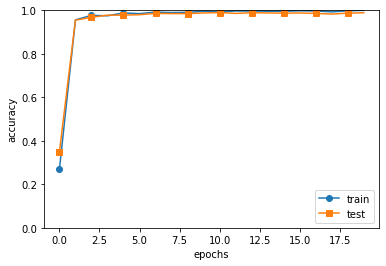

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

以上で七章は終了となります。